In [63]:
import numpy as np
import time
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [64]:
qr = qiskit.QuantumRegister(3)
qubit_list = [0, 1, 2]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [65]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [66]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [67]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [68]:
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [69]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [70]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.733 0.199 0.211 0.072 0.199 0.058 0.065 0.017]
 [0.089 0.627 0.022 0.173 0.024 0.175 0.006 0.044]
 [0.066 0.02  0.622 0.151 0.016 0.004 0.175 0.041]
 [0.009 0.061 0.053 0.507 0.001 0.013 0.021 0.144]
 [0.087 0.019 0.018 0.004 0.635 0.189 0.174 0.052]
 [0.007 0.067 0.002 0.024 0.066 0.491 0.029 0.16 ]
 [0.008 0.003 0.065 0.023 0.056 0.014 0.477 0.136]
 [0.001 0.004 0.007 0.046 0.003 0.056 0.053 0.406]]


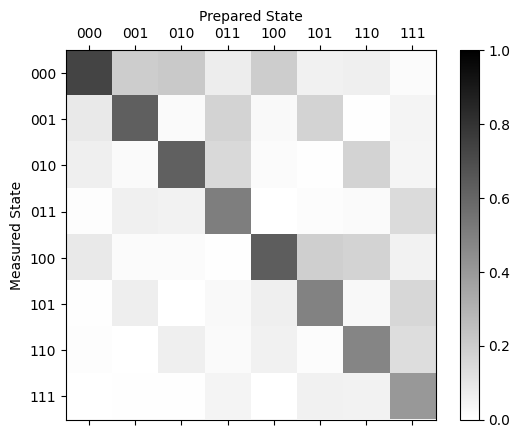

In [71]:
meas_fitter.plot_calibration()

In [72]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 0.562250
Average Measurement Fidelity of Q0: 0.826500


In [73]:
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[0])
ghz.cx(qr[0], qr[1])
ghz.cx(qr[0], qr[2])
ghz.measure([0,1,2], [0, 1, 2])

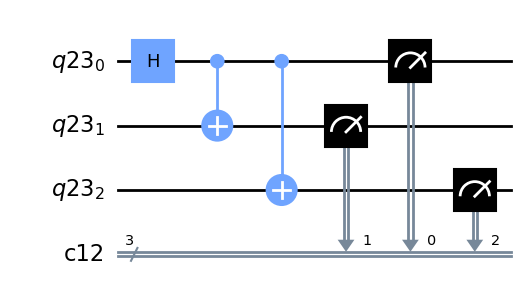

In [74]:
ghz.draw()

In [75]:
job = qiskit.execute([ghz], backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

In [76]:
# Results without mitigation
raw_counts = results.get_counts()
meas_filter = meas_fitter.filter
# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

In [77]:
print("Original Counts: ", raw_counts)
print("Mitigated Counts: ", mitigated_counts)

Original Counts:  {'001': 294, '111': 1067, '011': 353, '100': 320, '101': 393, '010': 335, '000': 1864, '110': 374}
Mitigated Counts:  {'000': 2425.4448138430485, '010': 89.49065598702185, '100': 5.43350737666759e-12, '111': 2485.0645301701056}


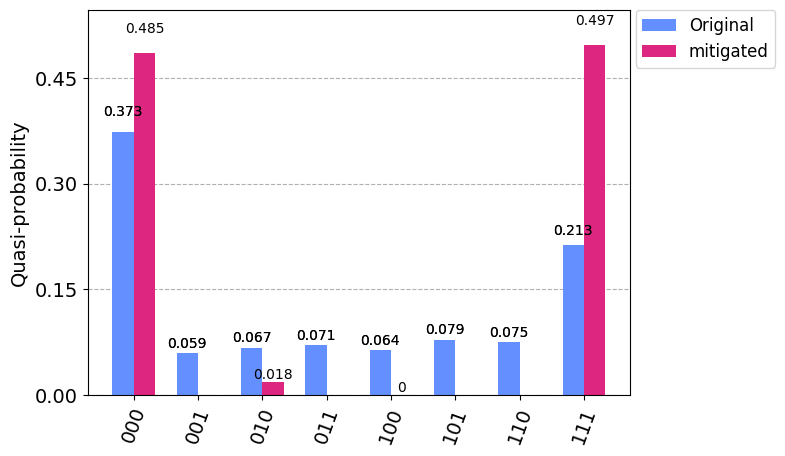

In [78]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['Original', 'mitigated'])